In [41]:
import traffic_sim
import matplotlib.pyplot as plt
import numpy as np
import random
import statistics

class Road:
    """has length, type, chance of random slowing down, Tracks where cars are
        Road looks like this:
        |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  | ... | <= end
        0  1  2  3  4  5  6  7  8  9  10 11 12 13 14 15 16 17 18 19 20    999
        c3 c3 c3 c3 c3    c2 c2 c2 c2 c2          c1 c1 c1 c1 c1
                                                   ^           ^
        c1 is car.car_number 1                     |           |
                                                c1's rear   c1's front
        """

    def __init__(self, road_length=1000, road_type='straight', slowdown_percent=1):
        self.road_length = road_length
        self.road_type = road_type
        self.slowdown_percent = slowdown_percent
        self.road_positions_array = None


class Car:

    def __init__(self, car_name, current_position = 0, current_speed = 0, car_size=5, car_type='normal',
                 acceleration=2, max_speed=33.333, spacing_multiplier=1, chance_of_deceleration=.10,
                 percent_of_population=1):
        self.car_name = car_name    # car's initial place in line
        self.car_size = car_size        # car length in meters
        self.current_speed = current_speed
        self.type = car_type            # normal, aggressive or commercial
        self.acceleration = acceleration #  meters/s of acelleration until reach their max_speed if they haveve room
        self.max_speed = max_speed      # desired speed
        self.spacing_multiplier = spacing_multiplier #want at least a number of meters equal to their speed in meters/s
        self.chance_of_deceleration = chance_of_deceleration  #percent chance that driver will randomly slow down by 2ms
        self.percent_of_population = percent_of_population #percent representation of population of drivers on road
        self.current_position = current_position    #current position of TAIL of car in road

        def __str__(self):
            return "car[{car_name}]'s object".format(self.car_name)

        def move_own_car(self):
            """Just update position of self"""
            self.current_position = (self.current_position + self.current_speed) % 1000
            return self.current_position

class Simulation:
    """ONE 60-second trial"""
    def __init__(self, number_of_cars_on_road=30, duration=60, time_interval=1,
                 car_objects_dict = {}, speed_snapshots_array=[],
                 position_snapshots_array=[], second=0 ):
        self.number_of_cars_on_road = number_of_cars_on_road
        self.duration = duration                  #duration of 1 simulation in seconds, currently 60 seconds
        self.time_interval = time_interval                #snapshot/step point of speed, currently 1 second
        self.car_objects_dict  = car_objects_dict # {[0: <carobject>, 1: <carobject>}
        self.speed_snapshots_array = speed_snapshots_array
        self.position_snapshots_array = position_snapshots_array
        self.second = second

    def make_cars(self):
        """Instantiates 30 cars & puts their objects in car_objects_dict"""
        for i, car_obj in enumerate((range(self.number_of_cars_on_road))):
            # TODO: need to pass it current_position
            self.car_objects_dict[i] = Car(i)

    def get_car_object_by_name(self, car_name):
        """Given a car's name return the car object"""
        return self.car_objects_dict[car_name]

    def layout_cars(self):
        """Updates each car's current_position and creates initial layout list"""
        distances_of_cars_array = np.round(np.linspace(0,1000,31)) #for 30 car, have 31 spaces
        layout_list = []
        for i in range(30):
            x = -1 * (i+2)
            tail_position = distances_of_cars_array[x]
            layout_list.append(tail_position)
            #update car object's current_position
            self.get_car_object_by_name(i).current_position = tail_position
        """car in front of car0 is car29
            car in front of car1 is car0
            car in front of car2 is car1 """
        return layout_list

    def move_all_cars(self):
        """Move car ONE second. Uses speed rules to determine speed
        updates car's current_position in car object
        reports speed to speed_snapshots_array
        reports position to position_snapshots_array"""
        for i in range(30):
            # 1. Update speed
            my_car = self.car_objects_dict[i]
            if i == 0:
                car_in_front = self.car_objects_dict[29]
            else:
                car_in_front = self.car_objects_dict[i-1]
            # collision occurs when car_in_front == my_front
            speed = self.determine_speed(my_car, car_in_front)
            self.speed_snapshots_array[self.second,i] = speed
            my_car.current_speed = speed
            # TODO ERROR! AttributeError: 'Car' object has no attribute 'move_own_car'
            # like hell it doesnt!
            # new_position = my_car.move_own_car()
            my_car.current_position = (my_car.current_position + my_car.current_speed) % 1000
            self.position_snapshots_array[self.second,i] = my_car.current_position

    def determine_speed(self, my_car, car_in_front):
        my_front = my_car.current_position + my_car.car_size
        current_speed = self.speed_snapshots_array[(self.second-1),my_car.car_name]
        #print("current speed for car{} is {}".format(my_car.car_name, current_speed))
        if current_speed < (my_car.max_speed-2):
        #     #will car collide?
        #     speed = current_speed + my_car.acceleration
        #     if car_in_front.current_position <= my_front + speed:
        #         speed =
        # TODO below is just a test of accellerating the cars 2ms each second
        # no rules
            speed = current_speed + my_car.acceleration
        else:
            speed = current_speed
        #speed = current_speed + my_car.acceleration
        return speed



    def run(self):
        """This runs ONE simulation or ONE 60-second trial"""
        # generate 2 empty np arrays for car speeds & car positions at each second
        self.speed_snapshots_array = np.zeros((self.duration, self.number_of_cars_on_road)) #(60,30)
        self.position_snapshots_array = np.zeros((self.duration, self.number_of_cars_on_road))
        self.make_cars()
        initial_layout_position_list = self.layout_cars()
        while self.second < 60:
        # TODO uncomment this code block if minute loop doesnt work
        # # layout where each car needs to be on the road and store in car.current_position
            self.move_all_cars()
            self.second += 1
        # convert the speed_snapshots_array into a (30,) array of average speeds
        #a.sum(axis=0) # sum over rows for each of the 3 columns
        average_speeds_each_car_array = self.speed_snapshots_array.mean(axis=0)
        # you can pack it in tuples!
        #print("****")
        #print(average_speeds_each_car_array + average_speeds_each_car_array)
        return average_speeds_each_car_array, self.position_snapshots_array


In [42]:
%matplotlib inline

In [43]:
gigantic_speeds_each_car_array = np.array([])

for x in range(1000):
    simulation = Simulation()
    road = Road()
    average_speeds_each_car_array, position_snapshots_array = simulation.run()
    #print(average_speeds_each_car_array)
    if gigantic_speeds_each_car_array.size == 0:
        gigantic_speeds_each_car_array = average_speeds_each_car_array
    else:
        gigantic_speeds_each_car_array = np.vstack((gigantic_speeds_each_car_array,average_speeds_each_car_array))
    #gigantic_speeds_each_car_array = average_speeds_each_car_array

In [44]:
# all_trials_positions_array = np.zeros((60,30))   #then change to #10000
# all_trials_speeds_array = np.zeros((60,30))  #then change to #10000
# for x in range(10):   #cthen change to #10000
#     speed_snapshots_array, position_snapshots_array = simulation.run()
#     all_trials_speeds_array[x,] = speed_snapshots_array
#     all_trials_positions_array[x,] = positions_snapshots_array

TODO: μ speed for 1000 trials :
1. Make array/list of mean speed of each car for 1000 trials (30 cars, 1000 trials):
2. Update that array/list each trial

TODO: σ of avg speed for 1000 trials

##Optimal Speed
    

In [45]:
stan_dev_speed_per_car = gigantic_speeds_each_car_array.std(axis=1)  # standard deviation from μ speed of each car
all_trials_stan_dev_speed = np.sum(stan_dev_speed_per_car) / len(stan_dev_speed_per_car)  #standard dev of all cars
mean_speed_per_car = gigantic_speeds_each_car_array.mean(axis=1)     # μ speed for each car all trials
all_trials_mean_speed = np.sum(mean_speed_per_car) / len(mean_speed_per_car)  # μ speed for all cars all trials
print("*******")
print("μ speed for all cars all trials is {}".format(all_trials_mean_speed))
print("with a σ of {}".format(all_trials_stan_dev_speed))
print("Speed limit for this road should be {}".format(all_trials_stan_dev_speed + all_trials_mean_speed))

*******
μ speed for all cars all trials is 28.0
with a σ of 0.0
Speed limit for this road should be 28.0


##μ Speed per Trial Visualization

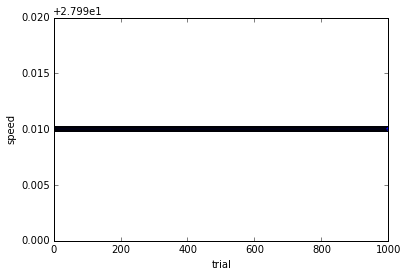

In [46]:
plt.scatter(range(1000),mean_speed_per_car)
plt.xlim(0,1000)
plt.xlabel("trial")
plt.ylabel("speed")
plt.show()

##Vehicle Traffic Movement Visualization for one minute

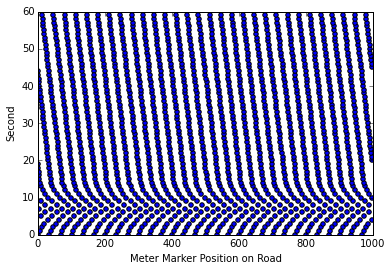

In [47]:
plt.ylim(0,60)
plt.xlim(0,1000)
plt.xlabel("Meter Marker Position on Road")
plt.ylabel("Second")
for i in range(30):
    plt.scatter(position_snapshots_array[:,i], range(60))
plt.show()